# Border recruitment assay analysis example

An ImageJ macro measures intensities of .tifs (with saved ROIs) in a given folder.

ROIs are assumed to be in the following order:
1. Background
2. Border
3. Non-border in cell 1
4. Non-border in cell 2

Multiple border regions can be analyzed (but maintain the expected ROI order).

The result of the ImageJ macro is a "tidy" dataset in .CSV form.

This code will handle calculating ratios, calculating statistical significance, and plotting.

With thanks to the [JCB SuperPlots paper](https://doi.org/10.1083/jcb.202001064) and [Marco Dalla Vecchia](https://doi.org/10.1083/jcb.202001064)

Last updated: 2025-01-17

In [1]:
import pandas as pd
import sys
import os
import re
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib
import matplotlib.pyplot as plt

# Keeping low-ish for faster plot generation while testing
plt.rc('figure', dpi=150) 

# Adopt to personal / journal preference
#matplotlib.rcParams['font.sans-serif'] = "Arial"
#matplotlib.rcParams['font.family'] = "sans-serif"
plt.rc('font', family='serif')

# Make exported plots' text seen as text in Adobe Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
input_csv_dir = "01-split-csv"
output_csv_dir = "./02-merged-csv"

order = ["Celsr1-WT", "Celsr1-test1", "Celsr1-test2", "Celsr1-test3", "Celsr1-test4"]

### Simulate data for testing purposes

In [3]:
def createSimulatedDataForTesting():
    np.random.seed(0)
    variants = ["Celsr1-WT", "Celsr1-test1", "Celsr1-test2", "Celsr1-test3", "Celsr1-test4"]
    # Apply different biases to the different simulated variants
    var_amounts = {"Celsr1-WT"    : 0,
                   "Celsr1-test1" : 350,
                   "Celsr1-test2" : -250,
                   "Celsr1-test3" : 90,
                   "Celsr1-test4" : 25,
                  }
    
    df = pd.DataFrame()

    for var in variants:
        for N in range(1, 4):      # three biological replicates
            for y in range(1, 13): # twelve technical replicates
                
                _fname = f"{var}-N{N}_9.22.24-{y:02}"
                _dict = {"Filename" : _fname}
                
                for c in range(1, 4): # three channels
                    _border     = f"C{c}_MeanInt_border"
                    _background = f"C{c}_MeanInt_background"
                    _nonborder1 = f"C{c}_MeanInt_non-border_cell1"
                    _nonborder2 = f"C{c}_MeanInt_non-border_cell2"

                    # Simulate values
                    border = 600*c + 70 * N + np.random.randint(0, 300) + var_amounts[var]
                    bg = 100*c + 10*N + np.random.randint(0, 20)
                    nonborder1 = 250*c + 27*N + np.random.randint(0, 50)
                    nonborder2 = 220*c + 15*N + np.random.randint(0, 45)
                    
                    _dict.update({_border: border,
                                  _background : bg,
                                  _nonborder1 : nonborder1,
                                  _nonborder2 : nonborder2
                                 })
                # Convert temporary dictionary to DataFrame then append
                _df = pd.DataFrame([_dict])

                if df.empty:
                    df = _df
                else:
                    df = df.merge(_df, how="outer")

    return df

test_df = createSimulatedDataForTesting()

In [4]:
def GetNumberOfChannels(df):
    # Select columns starting with "C" followed by an integer
    pattern = r'^C(\d+)_'
    filtered_columns = [col for col in df.columns if re.match(pattern, col)]
    
    # Extract unique integers from the filtered column names
    unique_integers = sorted({int(re.match(pattern, col).group(1)) for col in filtered_columns})

    return max(unique_integers)
    
def processDF(df):
    # Extract metadata from provided filename
    df["Protein"]   = df.Filename.str.split("-", expand = True)[0]
    df["mutation"]  = df.Filename.str.split("-", expand = True)[1]
    df["Mutation"]  = df["Protein"] + "-" + df["mutation"]
    df["Replicate"] = df.Filename.str.split("-", expand = True)[2].str.split("_", expand = True)[0]
    df["Date"]      = df.Filename.str.split("-", expand = True)[2].str.split("_", expand = True)[1]
    df["Border"]    = df.Filename.str.split("-", expand = True)[3]

    # Calculate the corrected ratio for border to non-border intensities
    number_of_channels = GetNumberOfChannels(df)
    for c in range(1, number_of_channels + 1):
        _border     = f"C{c}_MeanInt_border"
        _background = f"C{c}_MeanInt_background"
        _nonborder1 = f"C{c}_MeanInt_non-border_cell1"
        _nonborder2 = f"C{c}_MeanInt_non-border_cell2"

        _avg_nonborder                  = f"C{c}_MeanInt_nonborder"
        _avg_nonborder_with_bg_subtract = f"C{c}_MeanInt_nonborder_bg_subtract"
        _border_with_bg_subtract        = f"C{c}_MeanInt_border_bg_subtract"
        _corrected_border_to_nonborder  = f"C{c}_Corrected_border_to_nonborder_ratio"

        # Subtract background from border
        df[_border_with_bg_subtract] = df[_border] - df[_background]

        # Average non-border and then subtract background
        df[_avg_nonborder]                  = (df[_nonborder1] + df[_nonborder2]) / 2
        df[_avg_nonborder_with_bg_subtract] = df[_avg_nonborder] - df[_background]

        # Calculate corrected ratio
        df[_corrected_border_to_nonborder] = df[_border_with_bg_subtract] / df[_avg_nonborder_with_bg_subtract]
        
    return df

def createReplicateAverages(df, col):
    ReplicateAverages = (df.groupby(["Mutation", "Replicate"], as_index = False)
                         .agg({col:"mean"})
                        )
    
    ReplicateAvePivot = ReplicateAverages.pivot_table(
        columns = "Mutation",
        values = col,
        index = "Replicate",
    )

    # Make the column order of the pivot table match
    ReplicateAvePivot = ReplicateAvePivot[order]
    
    return ReplicateAverages, ReplicateAvePivot

### Read csv files and merge

In [5]:
if not os.path.exists(output_csv_dir):
    os.makedirs(output_csv_dir)

input_CSVs = os.listdir(input_csv_dir)

merged_df = pd.DataFrame()

for f in input_CSVs:
    f_path = os.path.join(input_csv_dir, f)

    df = pd.read_csv(f_path)
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = merged_df.merge(df, how='outer')

### Introduce simulated data

In [6]:
#merged_df.drop(columns = [" "], inplace=True) 

a = pd.concat([merged_df, test_df])
merged_df = processDF(a)

## Plot and evaluate statistical significance
Note: The number of biological replicates is 3.
For a two-tailed Mann Whitney U test, the smallest significance level is 0.1

Here, I'm choosing to do Welch's t-test

In [7]:
def makesuperplot(df, col, ylabel=None):
    ReplicateAverages, RepAvePivot = createReplicateAverages(df, col)
    
    # all data points
    ax = sns.swarmplot(data = df, 
                       y = col,
                       x = "Mutation",
                       hue = "Replicate",
                       order = order,
                       marker = "o",
                       linewidth = 0,
                       legend = True,
                       alpha = 0.5,
                       zorder = 0,
                      )
    
    # dot for mean of each replicate
    ax = sns.pointplot(data = df,
                       y = col,
                       x = "Mutation",
                       hue = "Replicate",
                       linestyle = "none",
                       errorbar = None,
                       markers = ["o","s", "^"],
                       dodge = True,
                       markeredgecolor = "black",
                       markeredgewidth = 1.1, 
                       legend = False,
                       zorder = 1,
                      )
    
    # standard error bars of mean values of each replicate
    ax = sns.pointplot(data = ReplicateAverages,
                       y = col, 
                       x = "Mutation",
                       linestyle = "none",
                       hue = "Mutation",
                       capsize = 0.3,
                       errorbar = "se",
                       err_kws = {'linewidth':1.4},
                       marker = "_",
                       markersize = 50,
                       markeredgewidth = 1.4,
                       palette = "dark:black",
                       legend = False,
                       order = order,
                       zorder = 2
                      )

    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)

    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    # Use for plotting significance bars
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    p_vals = []

    print("Welch's t-test (two-sided)")
    for col in RepAvePivot.columns:
        #p_val = mannwhitneyu(ReplicateAvePivotC1["Celsr1-WT"], ReplicateAvePivotC1[col],
        #                  alternative="two-sided",
        #                  method="exact").pvalue
        p_val = ttest_ind(RepAvePivot["Celsr1-WT"], RepAvePivot[col],
                          equal_var=False, # Welch's t-test
                           alternative="two-sided",
                         ).pvalue
        print(f"p-value for {col} and Celsr1-WT is: {p_val}")
        p_vals.append(p_val)
    
    # get indices of columns with p-values less than 0.05
    significance_level = 0.05
    significant_indices = [i for i, x in enumerate( np.array(p_vals)) if x < significance_level]
    
    for s in significant_indices:
        # Put the bars on different levels
        level = len(significant_indices) - s

        x1 = 0
        x2 = s
        bar_h = (yrange * 0.08 * level) + top
        bar_tips = bar_h - (yrange * 0.02)
        # Plot bar
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_h, bar_h, bar_tips], lw=1, c="black")
        
        p = p_vals[s]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'

        text_height = bar_h + (yrange*0.01)
        plt.text((x1+x2) * 0.5, text_height, sig_symbol, ha="center", c="black")
        
    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

Welch's t-test (two-sided)
p-value for Celsr1-WT and Celsr1-WT is: 1.0
p-value for Celsr1-test1 and Celsr1-WT is: 0.0003606411331944054
p-value for Celsr1-test2 and Celsr1-WT is: 0.001002955049556444
p-value for Celsr1-test3 and Celsr1-WT is: 0.01231622498169218
p-value for Celsr1-test4 and Celsr1-WT is: 0.09808263571920804


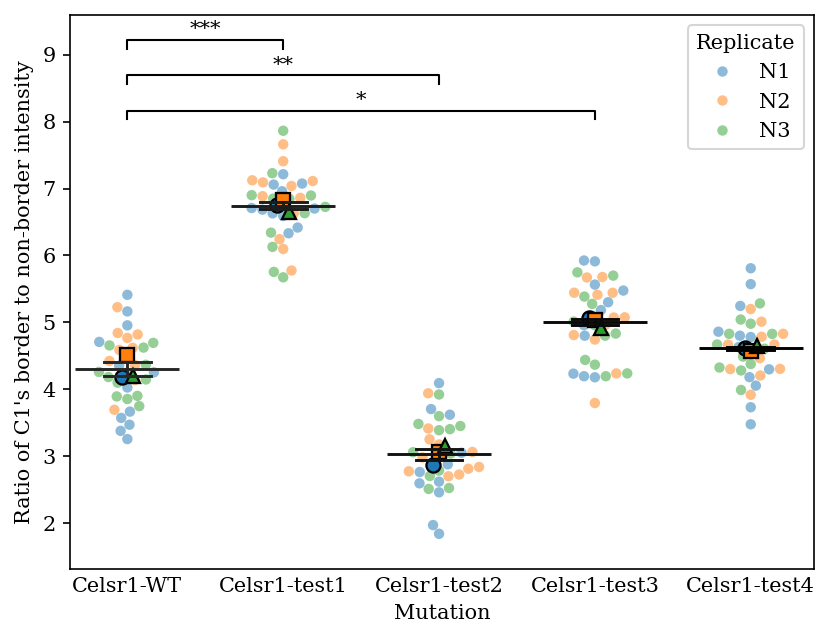

In [8]:
makesuperplot(merged_df, "C1_Corrected_border_to_nonborder_ratio",
              "Ratio of C1's border to non-border intensity")

Welch's t-test (two-sided)
p-value for Celsr1-WT and Celsr1-WT is: 1.0
p-value for Celsr1-test1 and Celsr1-WT is: 0.0005688027183836374
p-value for Celsr1-test2 and Celsr1-WT is: 0.0008458452327405523
p-value for Celsr1-test3 and Celsr1-WT is: 0.025476220386761988
p-value for Celsr1-test4 and Celsr1-WT is: 0.22859489548181347


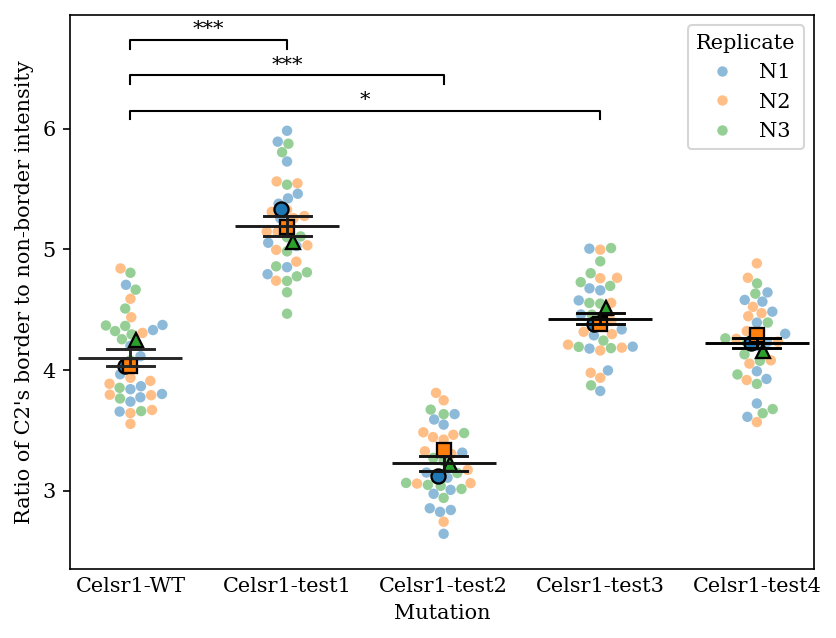

In [9]:
makesuperplot(merged_df, "C2_Corrected_border_to_nonborder_ratio",
             "Ratio of C2's border to non-border intensity")

## Save CSV files

In [10]:
def saveReplicateAveragesToCSV(df, col):
    ReplicateAverages, ReplicateAvePivot = createReplicateAverages(df, col)
    output_ReplicateAvgs_name = os.path.join(output_csv_dir, f"{col}_replicate_avg.csv")
    ReplicateAverages.to_csv(output_ReplicateAvgs_name, index=False)

saveReplicateAveragesToCSV(merged_df, "C1_Corrected_border_to_nonborder_ratio")
saveReplicateAveragesToCSV(merged_df, "C2_Corrected_border_to_nonborder_ratio")

# Save whole DataFrame
output_processed_df_name = os.path.join(output_csv_dir, "merged_data.csv")
merged_df.to_csv(output_processed_df_name, index=False)